In [38]:
import os
import numpy as np
import pandas as pd
from yahoo_fin.stock_info import get_data
from matplotlib import pyplot as plt
import matplotlib.ticker as mtick
from scipy.stats import binom

plt.style.use('ggplot')

In [36]:
#Probability of getting threshold or more heads
threshold=17
print("Probability of getting threshold or more heads:", 1-binom.cdf(k=threshold-1, n=25, p=0.5))

idx = pd.MultiIndex.from_product((range(10000), range(25)),
                             names=('period', 'set'))
df = pd.DataFrame(data=np.random.choice([1,-1], (10000*25, 48)), index=idx)

positives = df.eq(1).sum(level=0).ge(threshold).sum(axis=1).to_frame(name='positives')
negatives = df.eq(-1).sum(level=0).ge(threshold).sum(axis=1).to_frame(name='negatives')

all_periods = pd.concat( (positives, negatives), axis=1 )

all_periods['total'] = all_periods.sum(1)

Probability of getting threshold or more heads: 0.05387607216835022


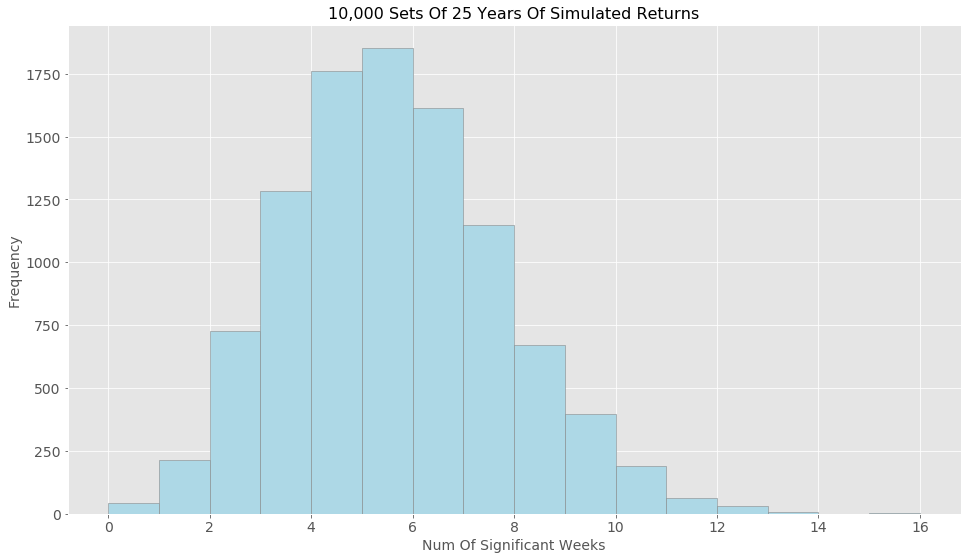

In [39]:
#Draw histogram
n, bins, _ = plt.hist(all_periods['total'], \
                      bins=np.arange(all_periods['total'].min(), all_periods['total'].max()+1), \
                      color='lightblue', edgecolor='grey')    
plt.title('10,000 Sets Of 25 Years Of Simulated Returns', fontsize=16)
plt.xlabel('Num Of Significant Weeks', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.gcf().set_size_inches(16, 9)
plt.tick_params(labelsize = 14)
plt.show()

In [37]:
#Print Frequency Table
freq_table = pd.DataFrame([bins[:-1], n], index=['bin', 'freq']).T
freq_table['percentile'] = freq_table['freq'].cumsum().div(freq_table['freq'].sum())
freq_table

,bin,freq,percentile
0,0.0,40.0,0.0040
1,1.0,232.0,0.0272
2,2.0,714.0,0.0986
3,3.0,1307.0,0.2293
4,4.0,1718.0,0.4011
5,5.0,1842.0,0.5853
6,6.0,1568.0,0.7421
7,7.0,1184.0,0.8605
8,8.0,686.0,0.9291
9,9.0,395.0,0.9686


In [23]:
#Get last days of 1987 so 1st week of 1988 shows a return
sp500 = get_data(ticker='^GSPC', start_date='12/24/1987', end_date='12/31/2018', index_as_date = False)
#keep date and close
sp500 = sp500.loc[:,['date', 'close']]
#Convert date to datetime
sp500['date'] = pd.to_datetime(sp500['date'])
#Get last price of week only, set index to Fri instead of Sun default
sp500 = sp500.resample('W', convention='end', on='date', \
                       loffset=pd.offsets.timedelta(days=-2)).apply({'close': 'last'})
#Make date separate column instead of index
sp500.reset_index(inplace=True)
sp500['entry date'] = sp500['date'].shift()
#add month, week of month and return
sp500['month'] = sp500['date'].apply(lambda x: x.month)
sp500['week of month'] = sp500['date'].apply(lambda x: (x.day-1)//7+1)
sp500['weekly return'] = sp500['close'].pct_change()
#Remove week 5 since not every month has 5 Fridays
sp500 = sp500.loc[sp500['week of month'] != 5]
#First row is NA, so drop
sp500.drop([0], inplace=True)
sp500.reset_index(drop=True, inplace=True)

In [24]:
sp500.head()

,date,close,entry date,month,week of month,weekly return
0,1988-01-01,247.080002,1987-12-25,1,1,-0.019641
1,1988-01-08,243.399994,1988-01-01,1,2,-0.014894
2,1988-01-15,252.050003,1988-01-08,1,3,0.035538
3,1988-01-22,246.500000,1988-01-15,1,4,-0.022019
4,1988-02-05,250.960007,1988-01-29,2,1,-0.023768


In [25]:
longs = pd.DataFrame()
shorts = pd.DataFrame()
years = sp500['date'].dt.year.unique()
for i in years:
    if i+25 >max(years):
        print("Reached end of data with year " + str(i))
        break

    #Training data consists of past 25 years. Test data is following year.
    #For example, train 1988 - 2012, test 2013. Then, train 1989 - 2013, test 2014
    train = sp500.loc[(sp500['date'].dt.year >= i) & (sp500['date'].dt.year < i+25),]
    test = sp500.loc[sp500['date'].dt.year == i+25,]

    train = train.groupby(['month', 'week of month'])
    pos = train.apply(lambda x: sum(x['weekly return']>0)).reset_index(name='pos count')
    neg = train.apply(lambda x: sum(x['weekly return']<=0)).reset_index(name='neg count')

    pos = pos.loc[pos['pos count'] >= 17]
    neg = neg.loc[neg['neg count'] >= 17]

    #get only those weeks that showed 17 weeks in pos/neg direction over prior 25 years
    pos = pos.merge(test, on=['month', 'week of month'], how='left')
    neg = neg.merge(test, on=['month', 'week of month'], how='left')

    longs = pd.concat([longs, pos], ignore_index=True)
    shorts = pd.concat([shorts, neg], ignore_index=True)

longs['side'] = 'long'
shorts['side'] = 'short'

#calculate profit per trade assuming $10,000 invested each time
longs['trade profit'] = longs['weekly return'] * 10000
#This is not compunded!
longs['growth of $10,000'] = longs['trade profit'].cumsum()+10000
#this way is compounded:
#longs['trade profit'] = (longs['weekly return']+1).cumprod() * 10000

#Reverse sign of returns for short trades, since a decline is actually a positive return
shorts['weekly return'] = shorts['weekly return'] * -1
shorts['trade profit'] = shorts['weekly return'] * 10000
shorts['growth of $10,000'] = shorts['trade profit'].cumsum()+10000


#Put long and shorts together in one data frame for equity curve
trades = pd.concat([longs.drop('pos count', axis=1), shorts.drop('neg count', axis=1)])
trades.sort_values(by='date', inplace=True)
trades.reset_index(drop=True, inplace=True)

#Redo growth of $10,000 since all trades are combined
trades['growth of $10,000'] = trades['trade profit'].cumsum()+10000

Reached end of data with year 1994


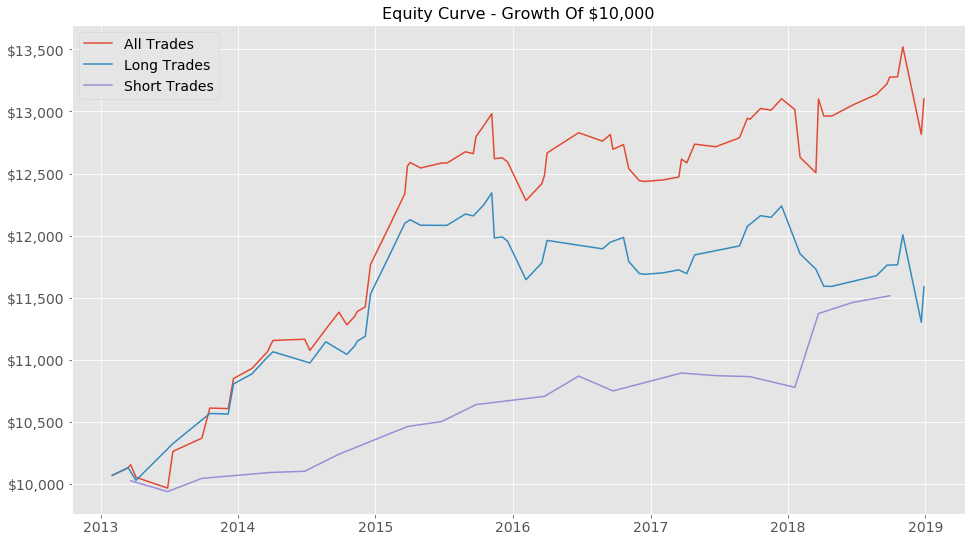

In [26]:
#Equity Curve - Growth Of $10,000
plt.plot(trades['date'], trades['growth of $10,000'])
plt.plot(longs['date'], longs['growth of $10,000'])
plt.plot(shorts['date'], shorts['growth of $10,000'])
plt.title('Equity Curve - Growth Of $10,000', fontsize=16)
plt.legend(['All Trades', 'Long Trades', 'Short Trades'], loc='upper left', fontsize=14)
#Format Y axis as dollars
plt.gca().yaxis.set_major_formatter(mtick.StrMethodFormatter('${x:,.0f}'))
plt.gcf().set_size_inches(16, 9)
plt.tick_params(labelsize = 14)
plt.show()

In [27]:
#Create performance report
frames = [trades, longs, shorts]

#Create empty data frame with row for all trades, longs and shorts. Will transpose for easier reading later
stats = pd.DataFrame(index = ['all trades', 'longs', 'shorts'])

stats['net profit'] = [sum(frame['trade profit']) for frame in frames]

#Gross profit is sum of all profitable trades
get_gross_profit = lambda x: x['trade profit'][x['trade profit']>0].sum()
stats['gross profit']= [get_gross_profit(frame) for frame in frames]

#Gross loss is sum of all losing trades
get_gross_loss = lambda x: x['trade profit'][x['trade profit']<0].sum()   
stats['gross loss'] = [get_gross_loss(frame) for frame in frames]

#Profit factors is gross profit divided by gross loss
stats['profit factor'] = stats['gross profit']/stats['gross loss'] * -1

stats['total trades'] = [len(frame.index) for frame in frames]
stats['win percentage'] = [sum(frame['trade profit']>0) for frame in frames]/stats['total trades']
stats['biggest win'] = [max(frame['trade profit']) for frame in frames]
stats['worst loss'] = [min(frame['trade profit']) for frame in frames]
stats['biggest winner as percent of gross profit'] = stats['biggest win']/stats['gross profit']
stats['worst loss as percent of gross loss'] = stats['worst loss']/stats['gross loss']

#Get percent of time in market, total days is the total time in the sp500 data frame
total_days = len(pd.date_range(start=sp500['date'][1],end=sp500['date'].values[-1],freq='D'))
#sum length of each trade within frame and divide by total number days examined
stats['pct time in market'] = [(frame['date'] - frame['entry date']).dt.days.sum()/total_days for frame in frames]

stats['sharpe'] = [frame['weekly return'].mean()/frame['weekly return'].std() for frame in frames]

get_sortino = lambda x: x['weekly return'].mean()/x['weekly return'][x['weekly return']<0].std()
stats['sortino'] = [get_sortino(frame) for frame in frames]

def get_consecutive(df):
    y = np.sign(df['weekly return'])
    #explanation of this: https://stackoverflow.com/a/27626699/2926358
    y = y * (y.groupby((y != y.shift()).cumsum()).cumcount() + 1)
    cons_wins = max(y)
    cons_losses = min(y) * -1
    return cons_wins, cons_losses

stats['consecutive wins'] = [get_consecutive(frame)[0] for frame in frames]
stats['consecutive losses'] = [get_consecutive(frame)[1] for frame in frames]

def get_returns(df):
    t = len(pd.date_range(start=df['date'][1],end=df['date'].values[-1],freq='D'))/365
    #use this defition of rate of return since we are using non-compounded rate of return
    r = 1 + (df['growth of $10,000'].values[-1] - 10000)/10000
    #r-1 is total return, r**(1/t) -1 is annualized return
    return r-1, r**(1/t) -1

stats['total return'] = [get_returns(frame)[0] for frame in frames]
stats['annualized return'] = [get_returns(frame)[1] for frame in frames]

stats['max drawdown'] = [(1-frame['growth of $10,000']/frame['growth of $10,000'].cummax()).max() for frame in frames]

stats= stats.transpose()

In [28]:
stats

,all trades,longs,shorts
net profit,3101.888104,1587.086925,1514.801179
gross profit,6250.174542,4413.574516,1836.600027
gross loss,-3148.286439,-2826.487591,-321.798848
profit factor,1.985262,1.561505,5.707292
total trades,76.000000,57.000000,19.000000
win percentage,0.657895,0.631579,0.736842
biggest win,595.019638,341.202238,595.019638
worst loss,-705.128319,-705.128319,-119.346053
biggest winner as percent of gross profit,0.095200,0.077307,0.323979
worst loss as percent of gross loss,0.223972,0.249472,0.370872
